In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import r_regression

import feature_utils, dict_utils, evaluation_utils, train_utils, plot_utils
import os, warnings, time

warnings.filterwarnings('ignore')

c:\Users\lawna\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lawna\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\lawna\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
battDict = np.load(os.path.join('.', 'batteryDictionary.npy'), allow_pickle=True).item()

In [ ]:
# Create features from the battery dictionary
T_V = feature_utils.create_T_V(battDict = battDict, cycleList = [str(x) for x in range(2,101)], avgUpToCycle=100)
dTdV = feature_utils.create_dTdV(battDict = battDict, cycleList = [str(x) for x in range(2,101)], avgUpToCycle=100)

Severson = feature_utils.create_Severson(battDict = battDict, cycleList = ['2', '10'])

TVKeynameUnique = dict_utils.get_unique_keyname_tuple(T_V)
dTdVKeynameUnique = dict_utils.get_unique_keyname_tuple(dTdV)
SeversonKeynameUnique = list(Severson.keys())

In [ ]:
# Set the markers automatically for train/test data, for plotting purposes
idx2C = []
idx3C = []

for i, cellNo in enumerate(battDict.keys()):
    if cellNo[0] == '2': idx2C.append(i)
    elif cellNo[0] == '3': idx3C.append(i)
        
train_index = np.array(idx3C)
test_index = np.array(idx2C)
markerArr = np.append(['v'] * len(idx3C), ['s'] * len(idx2C))

In [ ]:
# Set y values as well as the splits based on batch
y_train = T_V['cycleLife'][train_index].reshape(-1, 1)
y_test = T_V['cycleLife'][test_index].reshape(-1, 1)
y_all = np.concatenate((y_train, y_test))

yScaler = MinMaxScaler().fit(y_train)
y_train_scaled = yScaler.transform(y_train)
y_test_scaled = yScaler.transform(y_test)
y_all_scaled = yScaler.transform(y_all)

lengthList = [len(train_index), len(train_index)+len(test_index)]

## Create dataframe

In [ ]:
# Define modes for feature extraction
modeList = ['Charge', 'Discharge']

# Set the cycle range to be used for feature extraction
setCycleNo = 'Average_2to10'

# Initialize an empty DataFrame to store feature metadata and scores
feat_df = pd.DataFrame(columns=['dictionary', 'featName', 'valueArray', 'rScore'])

## 1. T(V)
featureDict = T_V.copy() # Copy the T(V) feature dictionary
featureKeynameUniqueList = TVKeynameUnique.copy() # Copy unique keynames for T(V)
keyCycle = setCycleNo # Use predefined cycle range
sample_size = featureDict[('Charge', 'Maximum', keyCycle)].size # Determine sample size from one feature

featureKeynameList = []

# Prepare target variable
X = np.empty((sample_size,0))
y = featureDict['cycleLife'].ravel()

# Generate feature keys for both modes and selected statistics
for keyMode in modeList:
    for keyStat in featureKeynameUniqueList[1][:-1]:
        featureKeynameList.append((keyMode, keyStat, keyCycle))
        
# Build feature matrix X by stacking each feature column
for feat in featureKeynameList: 
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
# Evaluate feature relevance using rScore
rScore = evaluation_utils.rScore(X, y, featureKeynameList, toPrint=False)

# Append results to the feature DataFrame
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'T_V', 'featName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)
    
    
## 2. dT/dV
featureDict = dTdV.copy()  # Copy dT/dV feature dictionary
X = np.empty((sample_size,0)) # Reset feature matrix

# Reuse same feature keys from T(V) for consistency
for feat in featureKeynameList: 
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
# Evaluate rScores for dT/dV features
rScore = evaluation_utils.rScore(X, y, featureKeynameList, toPrint=False)

# Append results to the feature DataFrame
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'dTdV', 'featName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)
    

## 3. Severson
featureDict = Severson.copy() # Copy Severson feature dictionary
featureKeynameList = SeversonKeynameUnique[:-1].copy() # Use all but last key (which is 'cyclelife')

X = np.empty((sample_size,0)) # Reset feature matrix

# Build feature matrix for Severson features
for feat in featureKeynameList: 
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
# Evaluate rScores for Severson features
rScore = evaluation_utils.rScore(X, y, featureKeynameList, toPrint=False)

# Append results to the feature DataFrame
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'Severson', 'featName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)

In [ ]:
featTemperatureChIndexList = [1, 2, 3, 4, 5, 6, 14, 17, 18, 19, 20]
featTemperatureIndexList = [1, 2, 3, 5, 6, 7, 8, 11, 12, 14, 17, 18, 19]

In [9]:
feat_df

dictionary                              featName  \
0         T_V      (Charge, Maximum, Average_2to10)   
1         T_V      (Charge, Minimum, Average_2to10)   
2         T_V      (Charge, Max-Min, Average_2to10)   
3         T_V     (Charge, Variance, Average_2to10)   
4         T_V         (Charge, Mean, Average_2to10)   
5         T_V     (Charge, Skewness, Average_2to10)   
6         T_V     (Charge, Kurtosis, Average_2to10)   
7         T_V   (Discharge, Maximum, Average_2to10)   
8         T_V   (Discharge, Minimum, Average_2to10)   
9         T_V   (Discharge, Max-Min, Average_2to10)   
10        T_V  (Discharge, Variance, Average_2to10)   
11        T_V      (Discharge, Mean, Average_2to10)   
12        T_V  (Discharge, Skewness, Average_2to10)   
13        T_V  (Discharge, Kurtosis, Average_2to10)   
14       dTdV      (Charge, Maximum, Average_2to10)   
15       dTdV      (Charge, Minimum, Average_2to10)   
16       dTdV      (Charge, Max-Min, Average_2to10)   
17       dTdV     (Charge, Variance, Average_2to10)   
18       dTdV         (Charge, Mean, Average_2to10)   
19       dTdV     (Charge, Skewness, Average_2to10)   
20       dTdV     (Charge, Kurtosis, Average_2to10)   
21       dTdV   (Discharge, Maximum, Average_2to10)   
22       dTdV   (Discharge, Minimum, Average_2to10)   
23       dTdV   (Discharge, Max-Min, Average_2to10)   
24       dTdV  (Discharge, Variance, Average_2to10)   
25       dTdV      (Discharge, Mean, Average_2to10)   
26       dTdV  (Discharge, Skewness, Average_2to10)   
27       dTdV  (Discharge, Kurtosis, Average_2to10)   
28   Severson                          Q_V_Variance   
29   Severson                              Q_V_Mean   
30   Severson                          Q_V_Skewness   
31   Severson                          Q_V_Kurtosis   
32   Severson                           Q_V_Minimum   
33   Severson                              Q_V_2_5V   
34   Severson                                 Qd_c2   
35   Severson                                Qd_c10   
36   Severson                             Qd_max-c2   
37   Severson                           Slope_2to10   
38   Severson                       Intercept_2to10   
39   Severson                       Avg_charge_time   
40   Severson                             IR_cycle2   
41   Severson                                Min_IR   
42   Severson                          IR_cycle10-2   
43   Severson                            MaxT_2to10   
44   Severson                            MinT_2to10   
45   Severson                       IntegralT_2to10   

                                           valueArray    rScore  
0   [1.509994571347126, 1.5127645818489401, 1.5076...  0.072721  
1   [1.4449298872792091, 1.4427388115384825, 1.442...  0.785032  
2   [0.6533708761996125, 0.6856564745395856, 0.651... -0.684239  
3   [0.4070999593145501, 0.4710513911779406, 0.404... -0.729785  
4   [1.4870319699651204, 1.4887642288250709, 1.484...  0.499514  
5   [-0.20051838853168585, -0.15572933794729968, -...  0.944128  
6   [0.07761675031274856, 0.035366711528229094, 0.... -0.797410  
7   [1.4632187659599616, 1.4620565411767208, 1.459...  0.782342  
8   [1.4130874357064465, 1.4082129630529525, 1.410...  0.791046  
9   [0.4990720390339746, 0.527542785543612, 0.4898... -0.378843  
10  [-0.030986745403406006, -0.001002449662531472,... -0.421704  
11  [1.4423704777938338, 1.4411514617133936, 1.440...  0.786618  
12  [-0.6391431127098971, -0.4451396699892526, -0.... -0.489427  
13  [0.10715646603224754, 0.024613793079870036, 0....  0.399816  
14  [1.512484438663261, 1.604029854323655, 1.62622... -0.686032  
15  [1.2636601218381922, 1.301029995664019, 1.4102... -0.004086  
16  [1.7128936626364777, 1.7799061689596638, 1.835... -0.663898  
17  [2.04037623347227, 2.1377061418058947, 2.24742... -0.714124  
18  [0.8649105495373044, 0.9075073420586245, 0.861... -0.682242  
19  [-0.6563950709120392, -0.5921565244339204, -0.... -0.776107  
20  [-0.42037721004546474, -0.8

### Model training using selected most optimal feature subset


Temperature model
rScore compared --> Test set

------------------------------------------------------------------------
Time elapsed: 2.9
Best score obtained was: -7.337872247981526
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Variance', 'Average_2to10') : -0.07761263577281792
T_V('Charge', 'Mean', 'Average_2to10') : 0.16592929565162987
T_V('Charge', 'Skewness', 'Average_2to10') : 0.21932637150455297
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.0343446667207337
dTdV('Charge', 'Mean', 'Average_2to10') : 0.008913976284033892
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.10351890905187502

Intercept: 0.6202443280977306
MAE_all: 19.2
MAPE_all: 7.3 %
RMSE_all: 25.9
RMSPE_all: 10.8 %
MAE_train: 18.4
MAPE_train: 8.4 %
RMSE_train: 25.9
RMSPE_train: 12.6 %
MAE_test: 20.9
MAPE_test: 5.1 %
RMSE_test: 25.9
RMSPE_test: 6.4 %
R2 normal-scale scores
All data r2-score: 0.918
Train data r2-score: 0.846
Test data r2-score: -7.338

Normal-scale scores
All data score: 0.918
Train data score: 

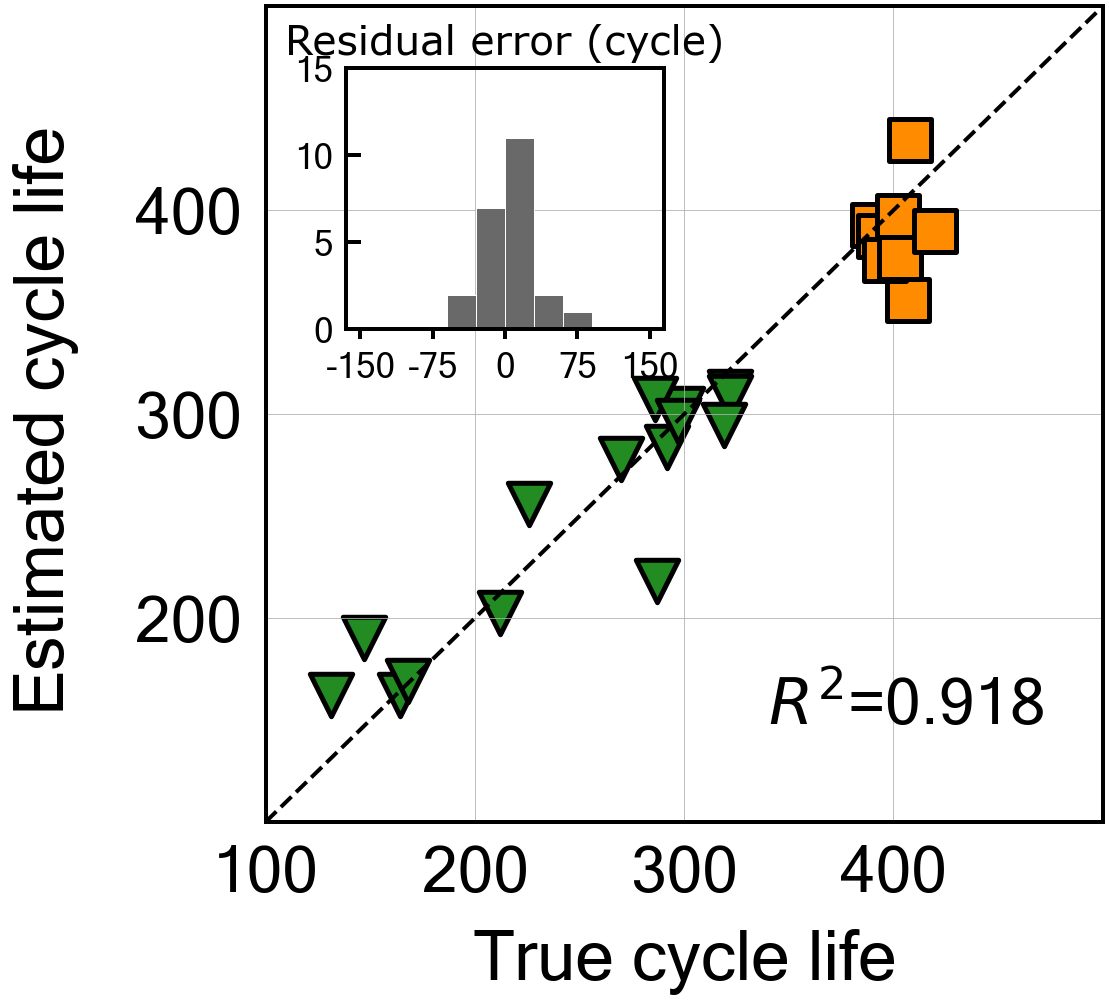

In [ ]:
# Define path to save output files
savepath = os.path.join('.', 'folder', 'filename')
# Set model name and feature column indices
modelName = "Temperature model"
columnIdx = featTemperatureChIndexList

# Stack all feature arrays into a 2D array and transpose to shape (samples, features)
X_array = np.vstack(feat_df.loc[:, 'valueArray']).transpose()

print("\nTemperature model\nrScore compared --> Test set")

# Select feature indices for model training
combo = [3, 4, 5, 14, 18, 20]
i = len(combo)
startTime = time.time()

# Initialize variables to track best model performance
r2ScoreBest = -100
featureKeynameListBest = []
saveFilePath = os.path.join(savepath, 'feat'+str(i)+'.png') # Path to save plot

# Extract selected features from full feature array
featureKeynameList = []
X_all = X_array[:, combo]

# Build list of feature names for reporting
for j in combo:
    featureKeynameList.append(feat_df.loc[j, 'dictionary'] + str(feat_df.loc[j, 'featName']))

# Split data into training and testing sets
X_train  = X_all[train_index]
X_test = X_all[test_index]

# Standardize features using training set statistics
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = np.concatenate((X_train_scaled, X_test_scaled))

# Initialize and train ElasticNet model with cross-validation
regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=20, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random')
model = regEN
model.fit(X_train_scaled, y_train_scaled)

# Evaluate model performance on test set
r2Score = model.score(X_test_scaled, y_test_scaled)

# Store best model and associated data
r2ScoreBest = r2Score
featureKeynameListBest = featureKeynameList
modelBest = model
X_all_scaled_best = X_all_scaled

# Print summary of training time and best score
stringOutputManual = ("\n------------------------------------------------------------------------\n" + 
            "Time elapsed: {:.1f}".format(time.time() - startTime) + 
            "\nBest score obtained was: " + str(r2ScoreBest))
print(stringOutputManual)

# Print detailed model evaluation and generate comparison plots
stringOutput = train_utils.print_result(setCycleNo, modelBest, X_all_scaled_best, y_all_scaled, featureKeynameListBest, idlst=lengthList, yScaler=yScaler)
stringOutput += plot_utils.build_all_comparison_graph(X_all_scaled_best, y_all_scaled, modelBest, len_list = [len(train_index), len(test_index)], yScaler=yScaler, 
                                                    name=modelName, markerArr = markerArr, markerSize=1800)#, save = saveFilePath)

## Optional: Exhaustive search through all possible combinations of selected feature pool.
### Uncomment and run to try


Temperature model
rScore compared --> Test set

------------------------------------------------------------------------
Time elapsed: 47.9
Best score obtained was: -23.204272973846827
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Skewness', 'Average_2to10') : 0.3037868970315945

Intercept: 0.6202443280977314
MAE_all: 29.4
MAPE_all: 10.2 %
RMSE_all: 36.4
RMSPE_all: 13.6 %
MAE_train: 22.3
MAPE_train: 10.1 %
RMSE_train: 31.5
RMSPE_train: 14.8 %
MAE_test: 42.7
MAPE_test: 10.6 %
RMSE_test: 44.2
RMSPE_test: 10.9 %
R2 normal-scale scores
All data r2-score: 0.838
Train data r2-score: 0.773
Test data r2-score: -23.204

Normal-scale scores
All data score: 0.838
Train data score: 0.773
Test data score: -23.204


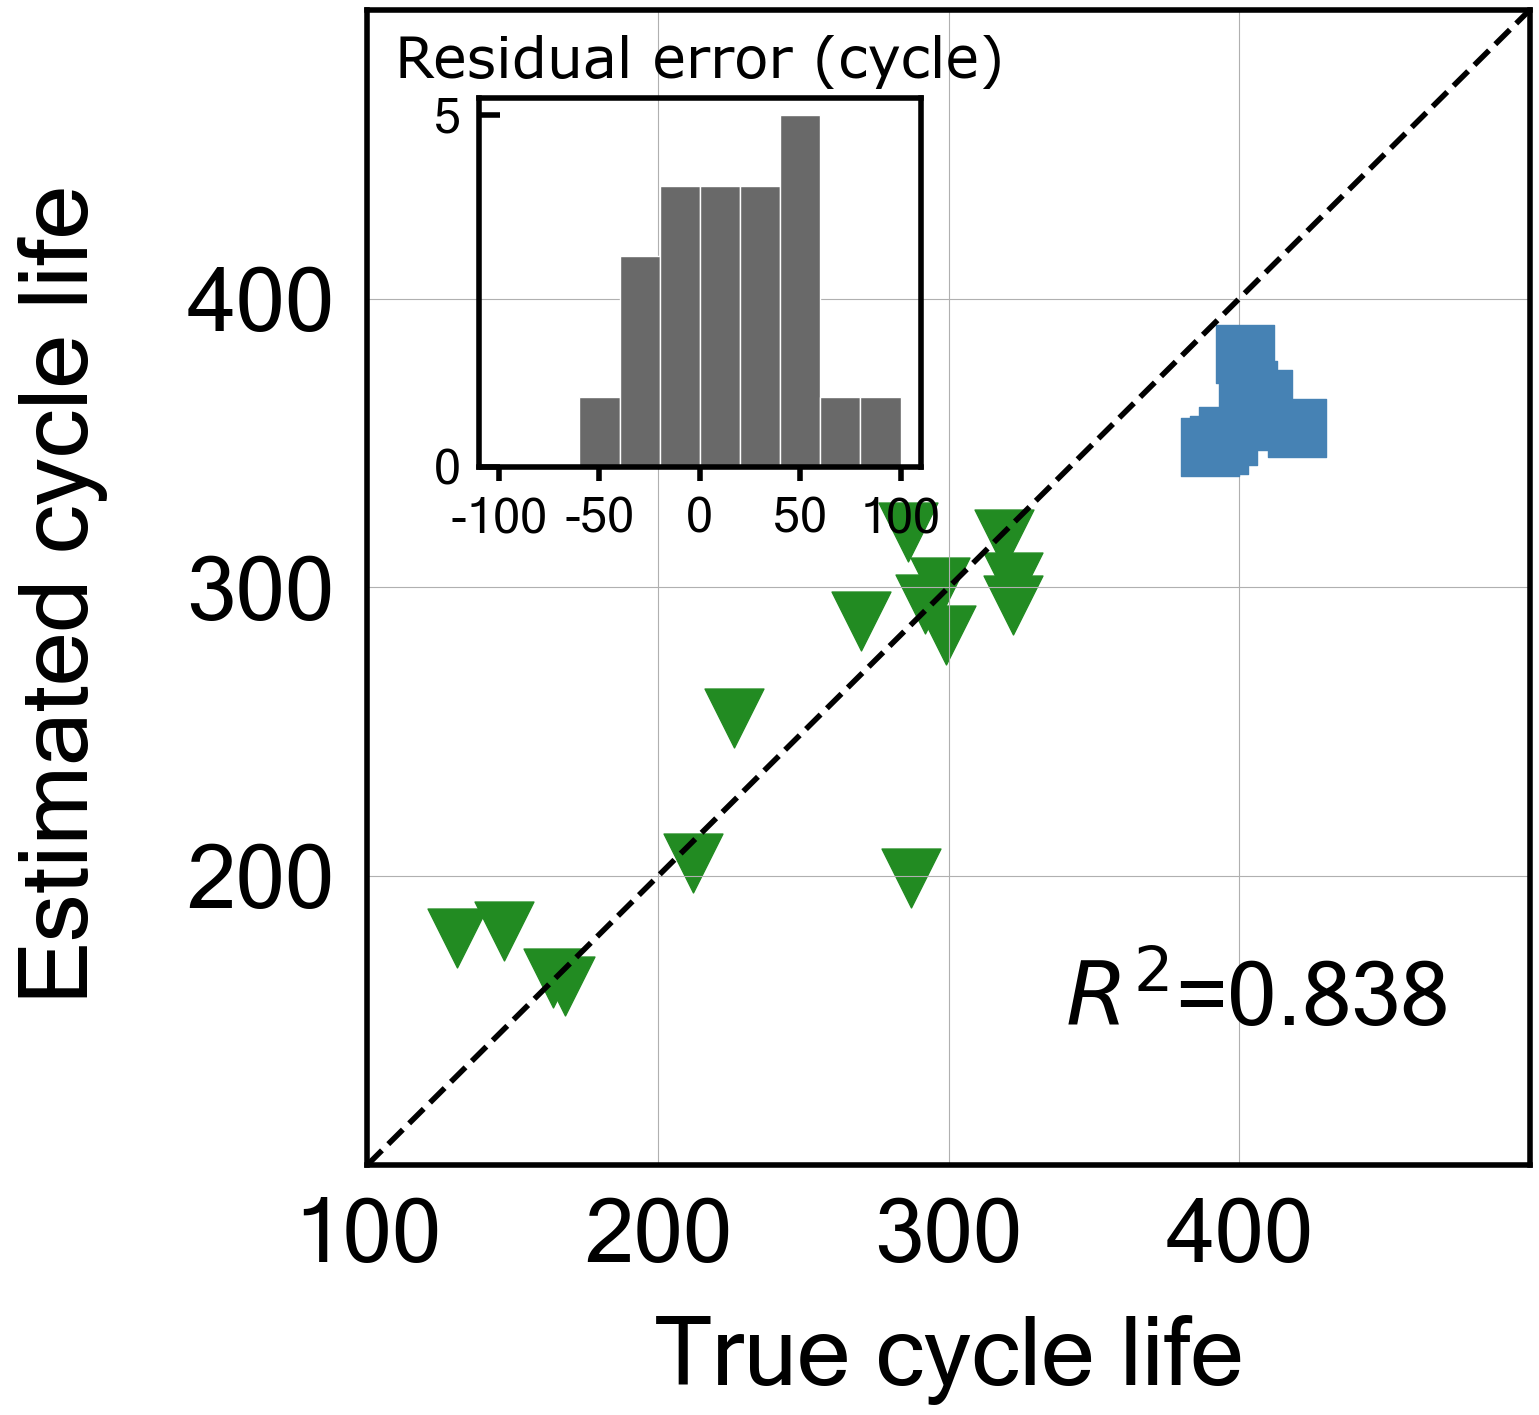


------------------------------------------------------------------------
Time elapsed: 305.1
Best score obtained was: -4.171074623092553
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Skewness', 'Average_2to10') : 0.3093056290089595
dTdV('Charge', 'Variance', 'Average_2to10') : -0.03424209577637152

Intercept: 0.6202443280977313
MAE_all: 19.9
MAPE_all: 7.8 %
RMSE_all: 27.6
RMSPE_all: 12.2 %
MAE_train: 21.0
MAPE_train: 9.6 %
RMSE_train: 30.8
RMSPE_train: 14.6 %
MAE_test: 17.7
MAPE_test: 4.4 %
RMSE_test: 20.4
RMSPE_test: 5.0 %
R2 normal-scale scores
All data r2-score: 0.907
Train data r2-score: 0.783
Test data r2-score: -4.171

Normal-scale scores
All data score: 0.907
Train data score: 0.783
Test data score: -4.171


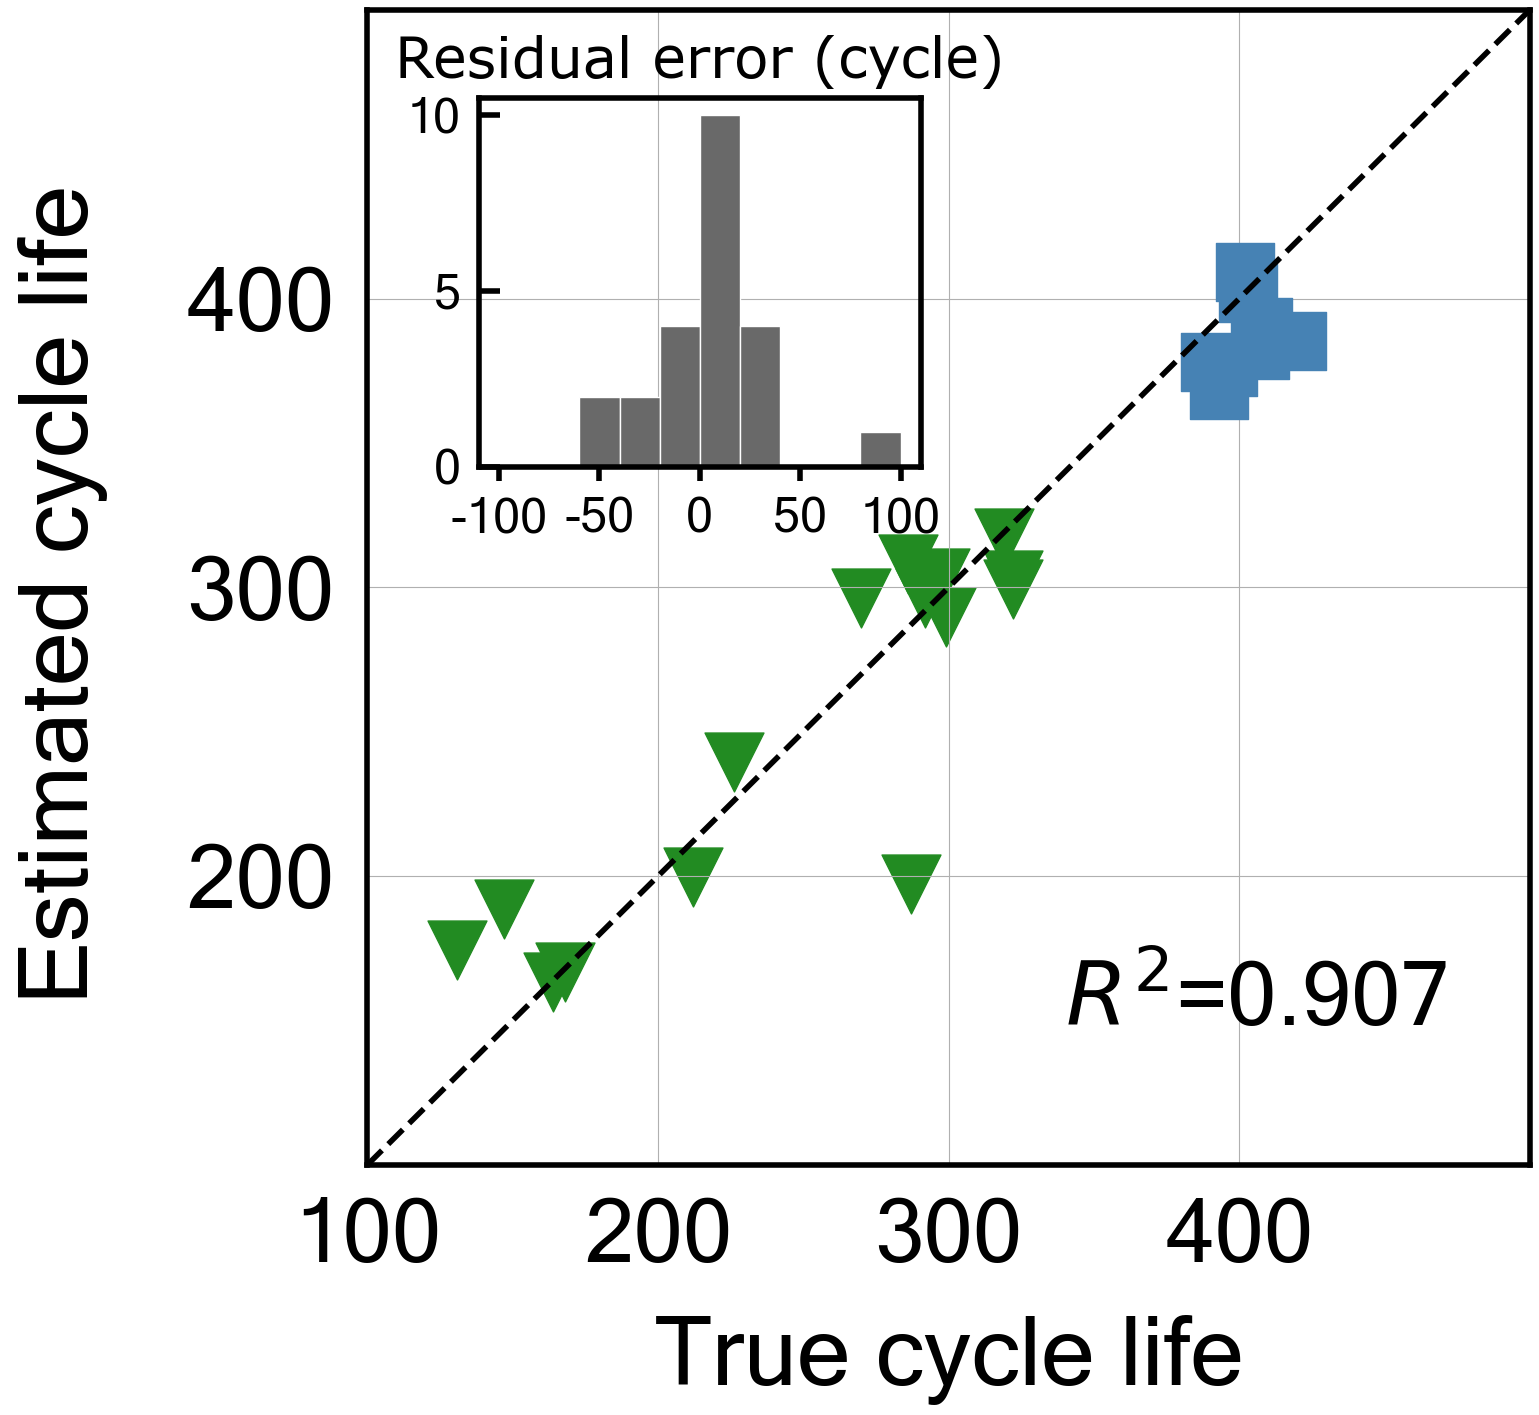


------------------------------------------------------------------------
Time elapsed: 1039.7
Best score obtained was: -8.270665766327467
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Skewness', 'Average_2to10') : 0.37714653016123634
dTdV('Charge', 'Variance', 'Average_2to10') : -0.04945102907977916
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.10342060732455269

Intercept: 0.6202443280977314
MAE_all: 19.5
MAPE_all: 7.5 %
RMSE_all: 26.8
RMSPE_all: 11.3 %
MAE_train: 18.2
MAPE_train: 8.5 %
RMSE_train: 26.5
RMSPE_train: 13.1 %
MAE_test: 22.0
MAPE_test: 5.5 %
RMSE_test: 27.4
RMSPE_test: 6.8 %
R2 normal-scale scores
All data r2-score: 0.912
Train data r2-score: 0.839
Test data r2-score: -8.271

Normal-scale scores
All data score: 0.912
Train data score: 0.839
Test data score: -8.271


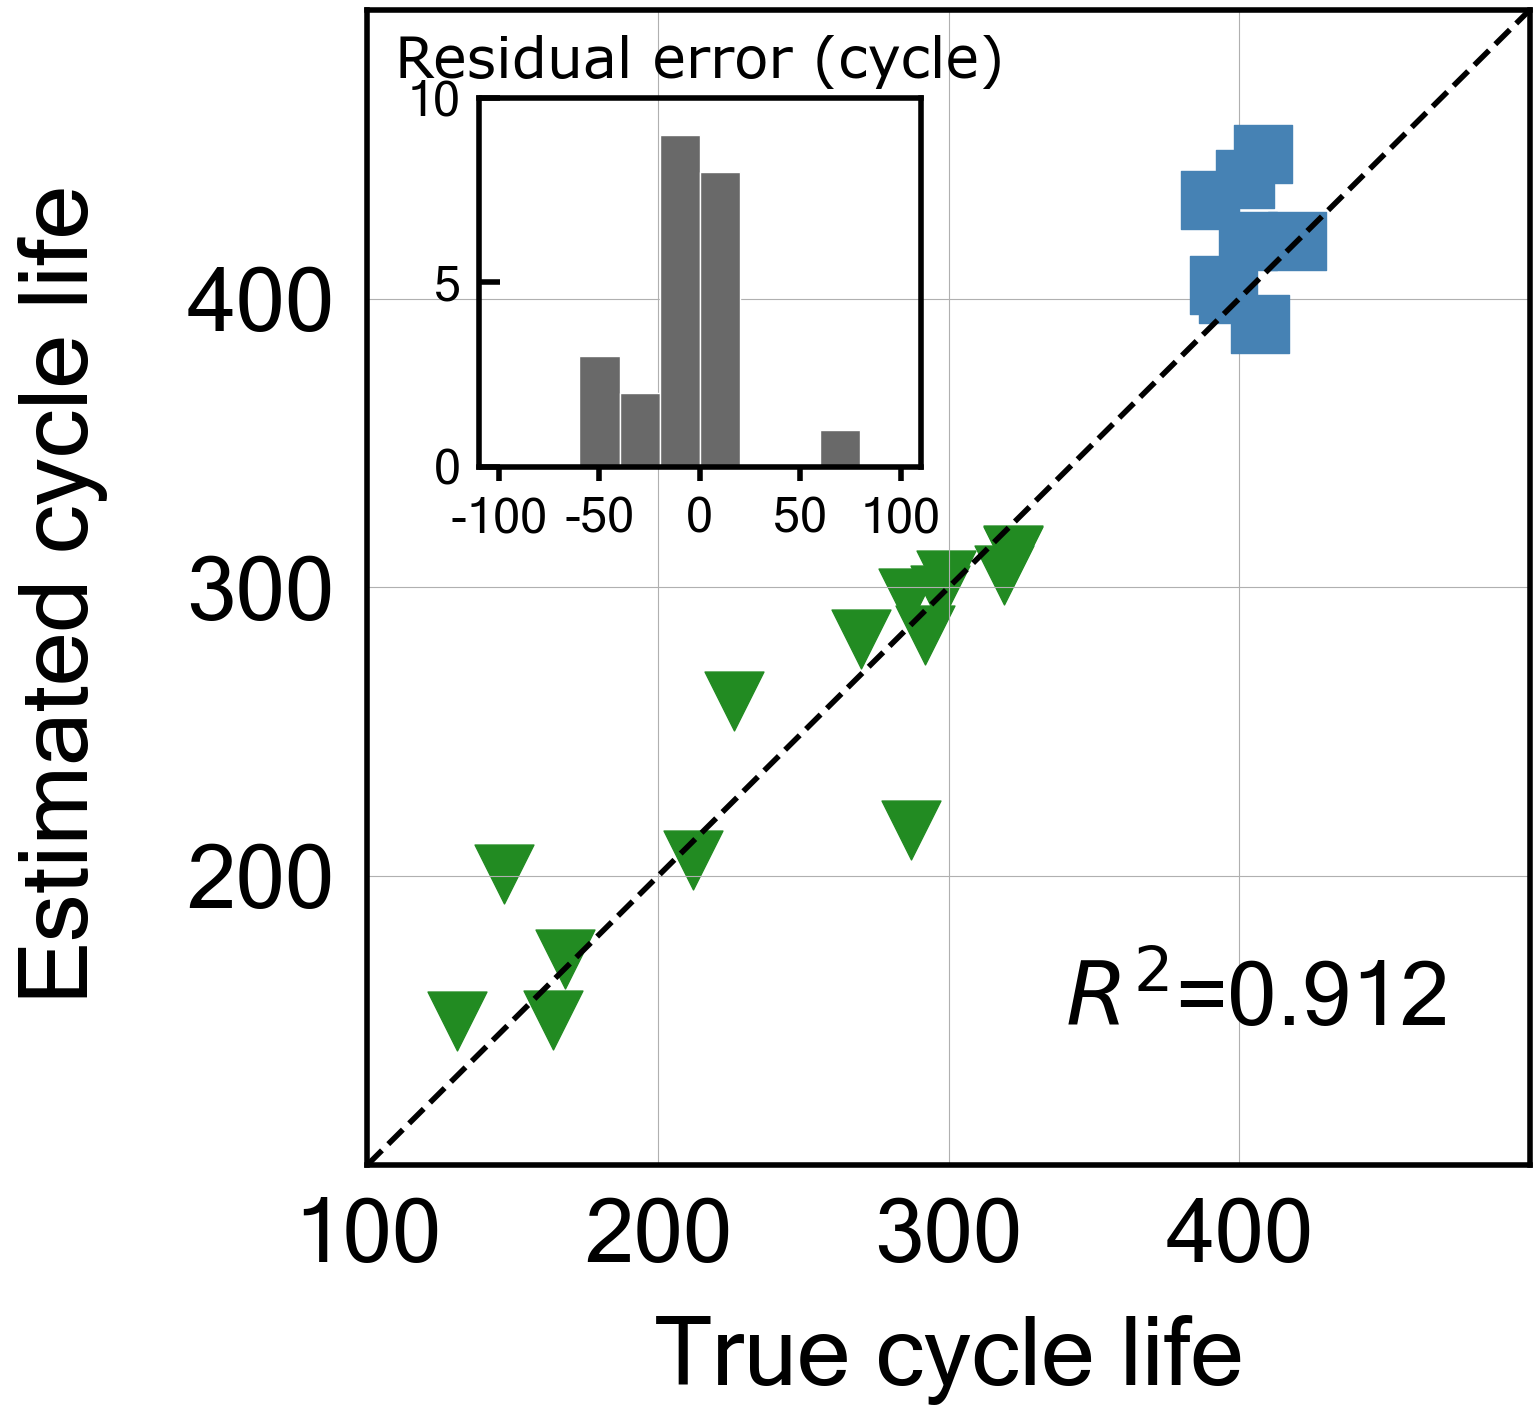


------------------------------------------------------------------------
Time elapsed: 2483.9
Best score obtained was: -3.1461603496362844
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Skewness', 'Average_2to10') : 0.35035594643954443
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.056128329112683305
dTdV('Charge', 'Variance', 'Average_2to10') : -0.0912209863569002
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.07859442264692647

Intercept: 0.6202443280977313
MAE_all: 18.2
MAPE_all: 7.2 %
RMSE_all: 23.6
RMSPE_all: 10.7 %
MAE_train: 18.8
MAPE_train: 8.8 %
RMSE_train: 26.0
RMSPE_train: 12.9 %
MAE_test: 17.0
MAPE_test: 4.2 %
RMSE_test: 18.3
RMSPE_test: 4.5 %
R2 normal-scale scores
All data r2-score: 0.932
Train data r2-score: 0.845
Test data r2-score: -3.146

Normal-scale scores
All data score: 0.932
Train data score: 0.845
Test data score: -3.146


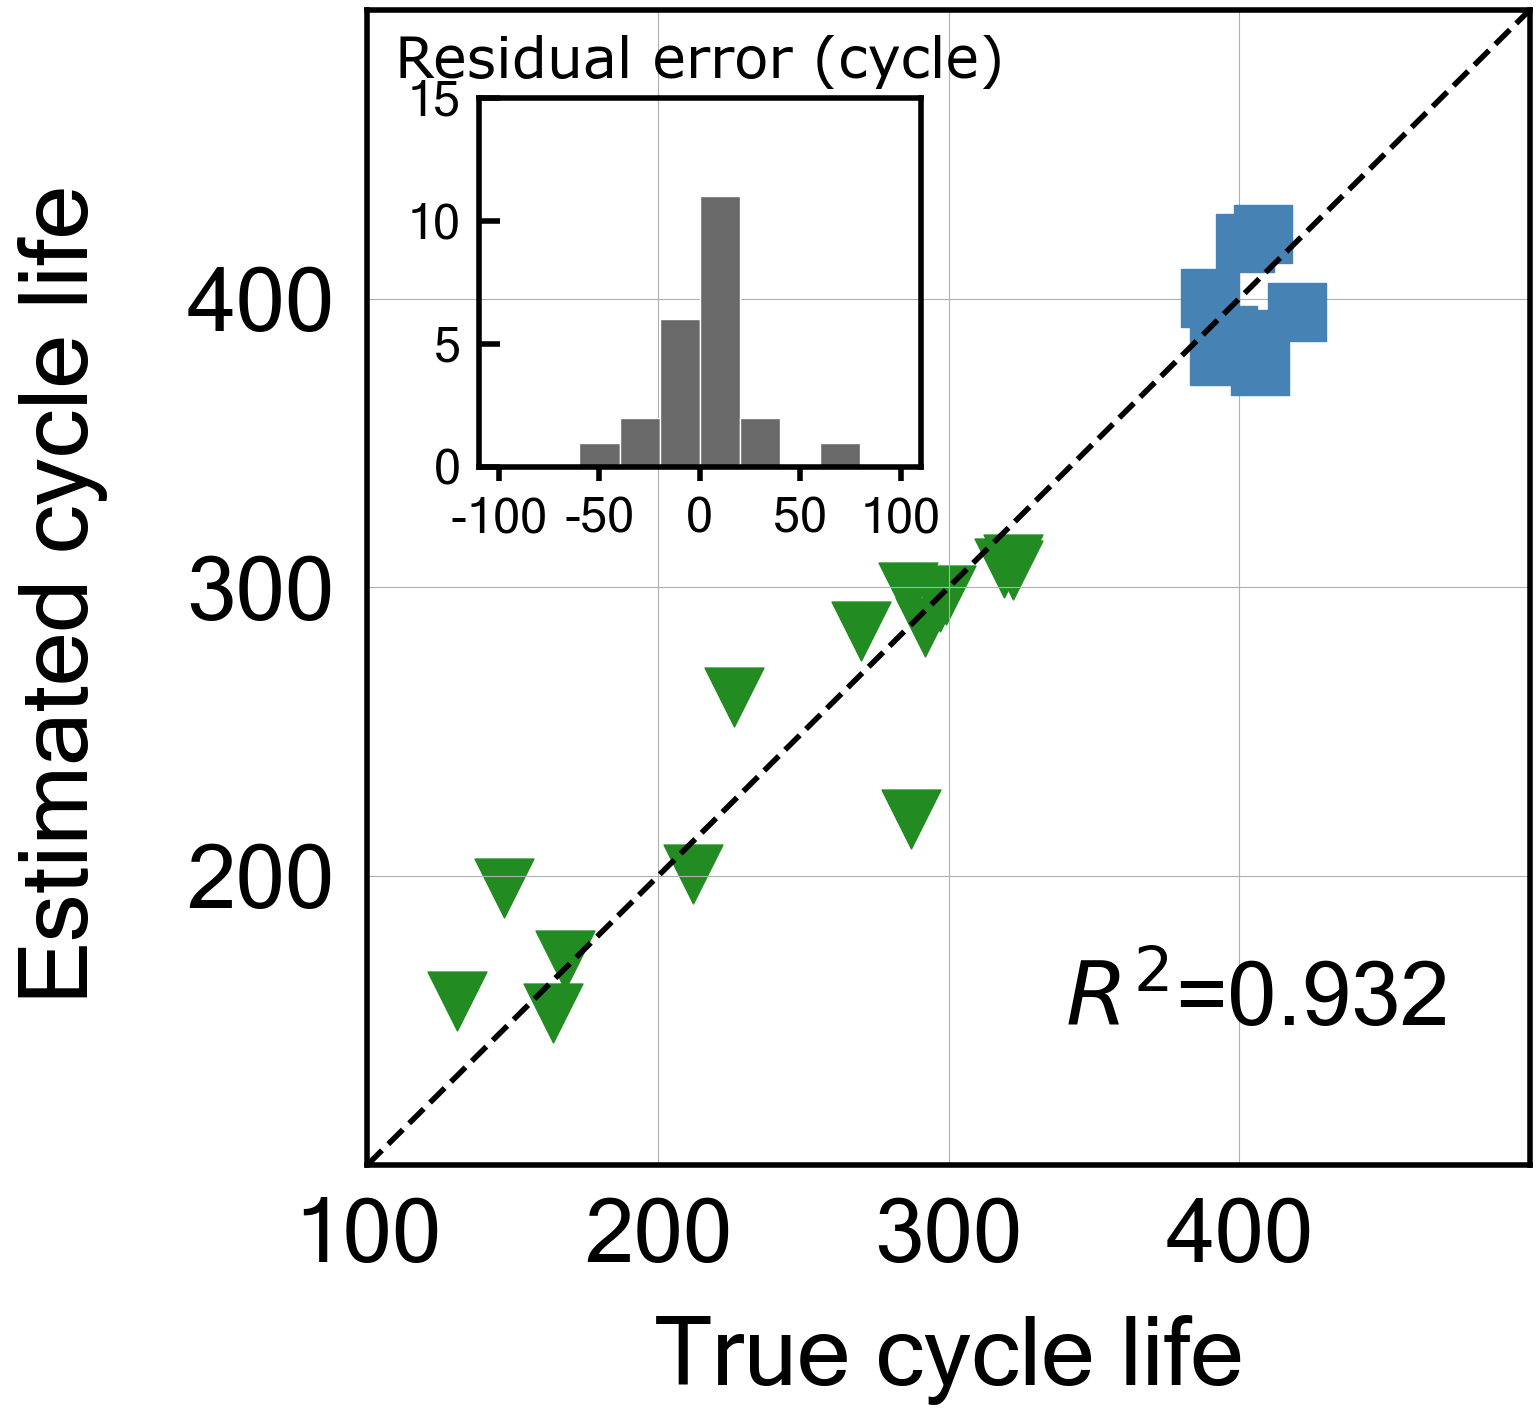


------------------------------------------------------------------------
Time elapsed: 4466.9
Best score obtained was: -7.207583029858945
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Variance', 'Average_2to10') : -0.0794715767793543
T_V('Charge', 'Mean', 'Average_2to10') : 0.17781726602694556
T_V('Charge', 'Skewness', 'Average_2to10') : 0.2128120256383496
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.043008574668738045
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.10570350108512692

Intercept: 0.6202443280977304
MAE_all: 19.0
MAPE_all: 7.2 %
RMSE_all: 25.8
RMSPE_all: 10.8 %
MAE_train: 18.3
MAPE_train: 8.4 %
RMSE_train: 25.8
RMSPE_train: 12.5 %
MAE_test: 20.3
MAPE_test: 5.0 %
RMSE_test: 25.7
RMSPE_test: 6.3 %
R2 normal-scale scores
All data r2-score: 0.919
Train data r2-score: 0.848
Test data r2-score: -7.208

Normal-scale scores
All data score: 0.919
Train data score: 0.848
Test data score: -7.208


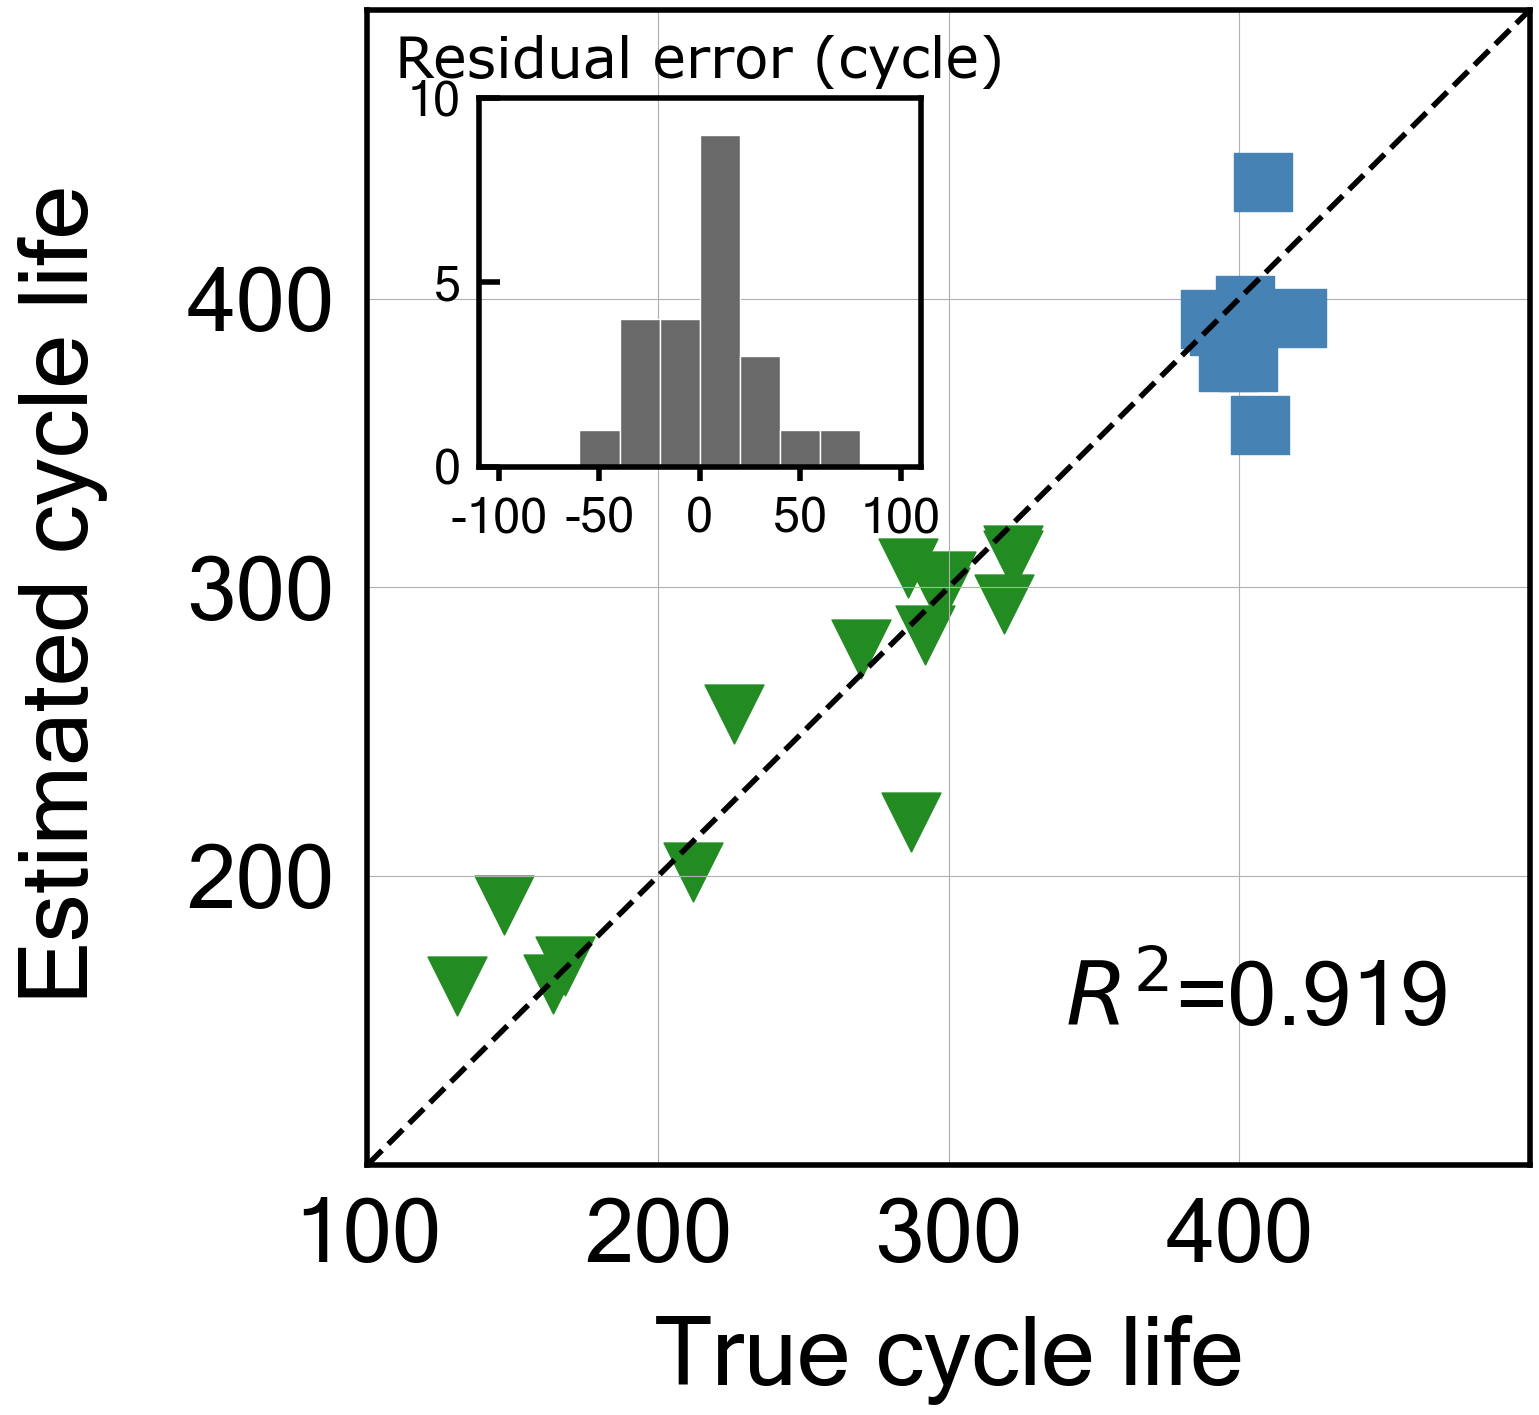


------------------------------------------------------------------------
Time elapsed: 6385.9
Best score obtained was: -7.337872247981554
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Variance', 'Average_2to10') : -0.07761263577281788
T_V('Charge', 'Mean', 'Average_2to10') : 0.1659292956516298
T_V('Charge', 'Skewness', 'Average_2to10') : 0.21932637150455297
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.034344666720733816
dTdV('Charge', 'Mean', 'Average_2to10') : 0.008913976284033844
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.10351890905187502

Intercept: 0.6202443280977306
MAE_all: 19.2
MAPE_all: 7.3 %
RMSE_all: 25.9
RMSPE_all: 10.8 %
MAE_train: 18.4
MAPE_train: 8.4 %
RMSE_train: 25.9
RMSPE_train: 12.6 %
MAE_test: 20.9
MAPE_test: 5.1 %
RMSE_test: 25.9
RMSPE_test: 6.4 %
R2 normal-scale scores
All data r2-score: 0.918
Train data r2-score: 0.846
Test data r2-score: -7.338

Normal-scale scores
All data score: 0.918
Train data score: 0.846
Test data score: -7.338


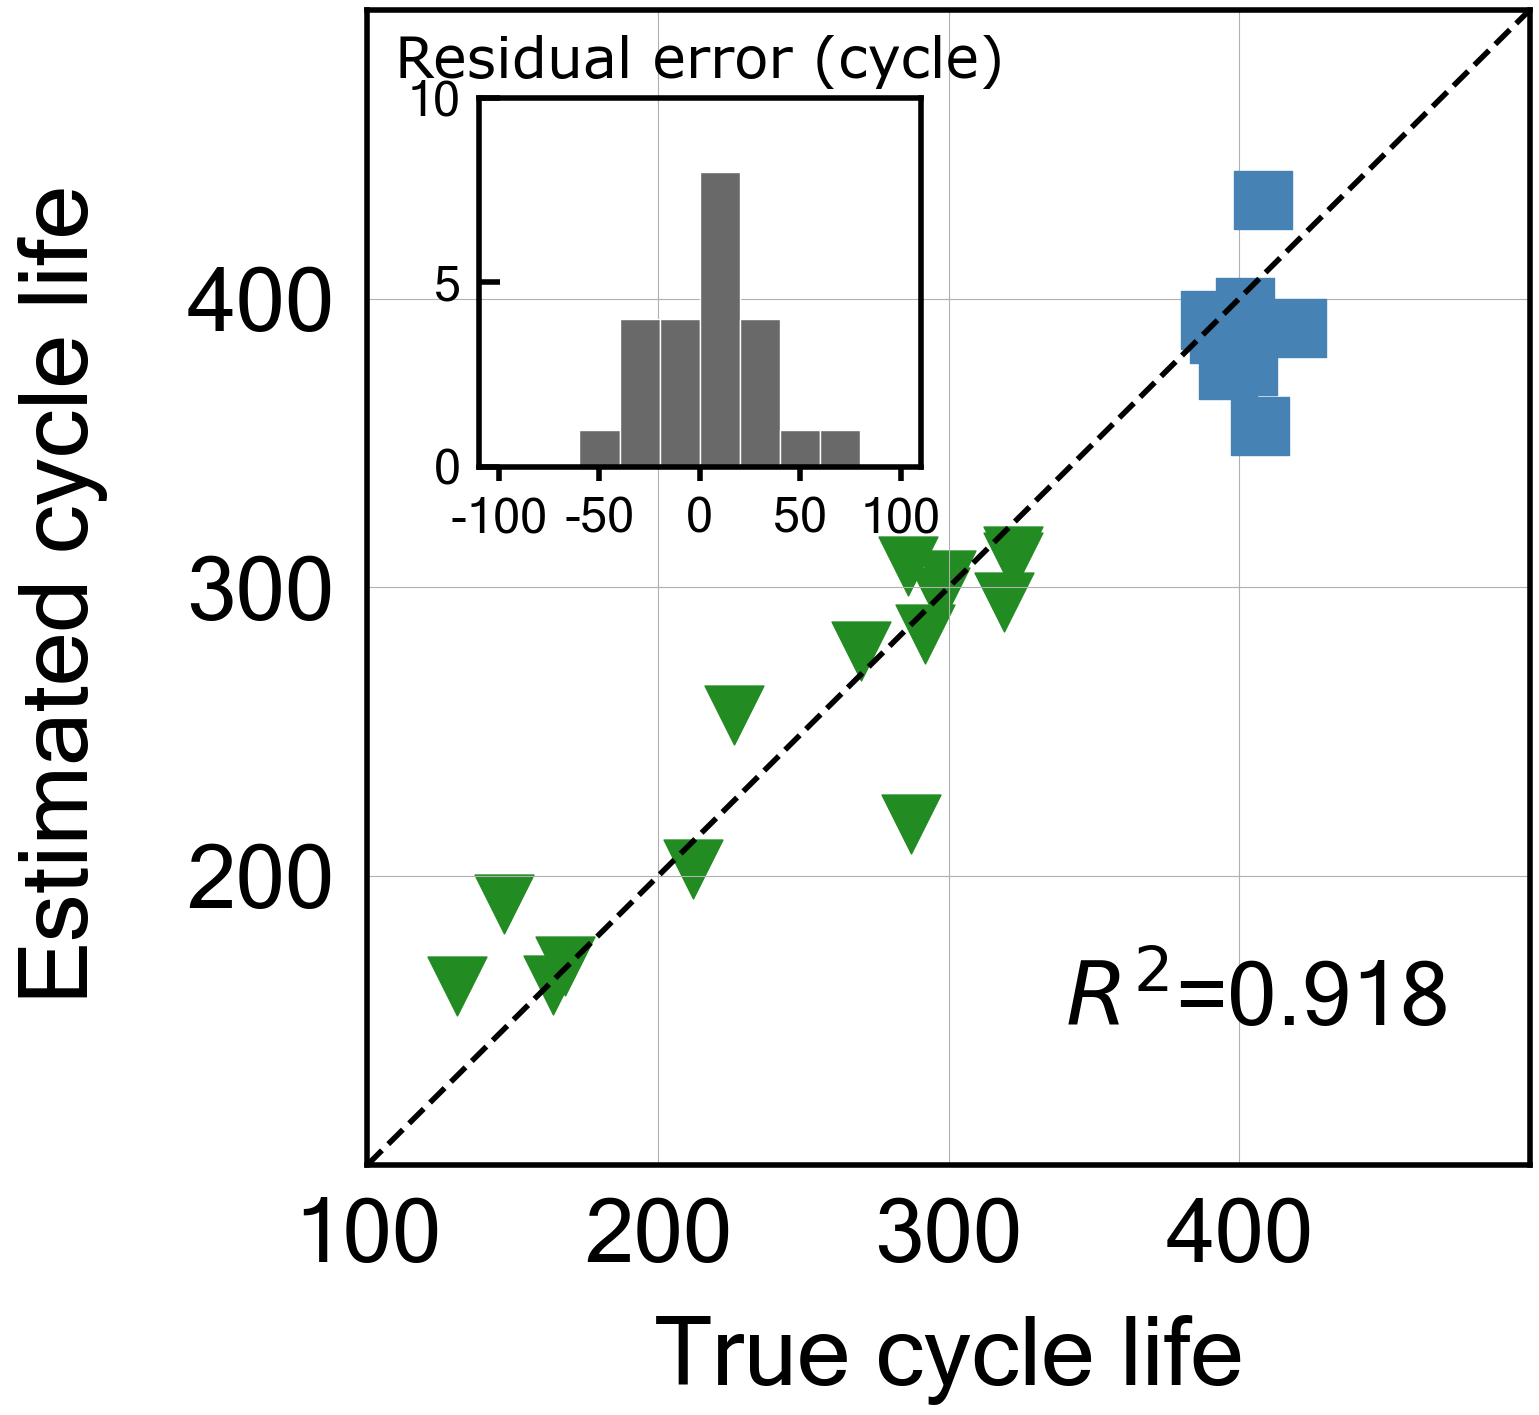


------------------------------------------------------------------------
Time elapsed: 7750.7
Best score obtained was: -7.781755970772764
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Max-Min', 'Average_2to10') : -0.0
T_V('Charge', 'Variance', 'Average_2to10') : -0.08228571331063379
T_V('Charge', 'Mean', 'Average_2to10') : 0.17389545553716002
T_V('Charge', 'Skewness', 'Average_2to10') : 0.2109358028884804
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.03995127042124551
dTdV('Charge', 'Mean', 'Average_2to10') : 0.008208337672092633
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.10262496017475756

Intercept: 0.6202443280977304
MAE_all: 19.4
MAPE_all: 7.3 %
RMSE_all: 26.1
RMSPE_all: 10.9 %
MAE_train: 18.4
MAPE_train: 8.4 %
RMSE_train: 25.9
RMSPE_train: 12.6 %
MAE_test: 21.4
MAPE_test: 5.3 %
RMSE_test: 26.6
RMSPE_test: 6.5 %
R2 normal-scale scores
All data r2-score: 0.916
Train data r2-score: 0.846
Test data r2-score: -7.782

Normal-scale scores
All data score: 0.916
Train data sco

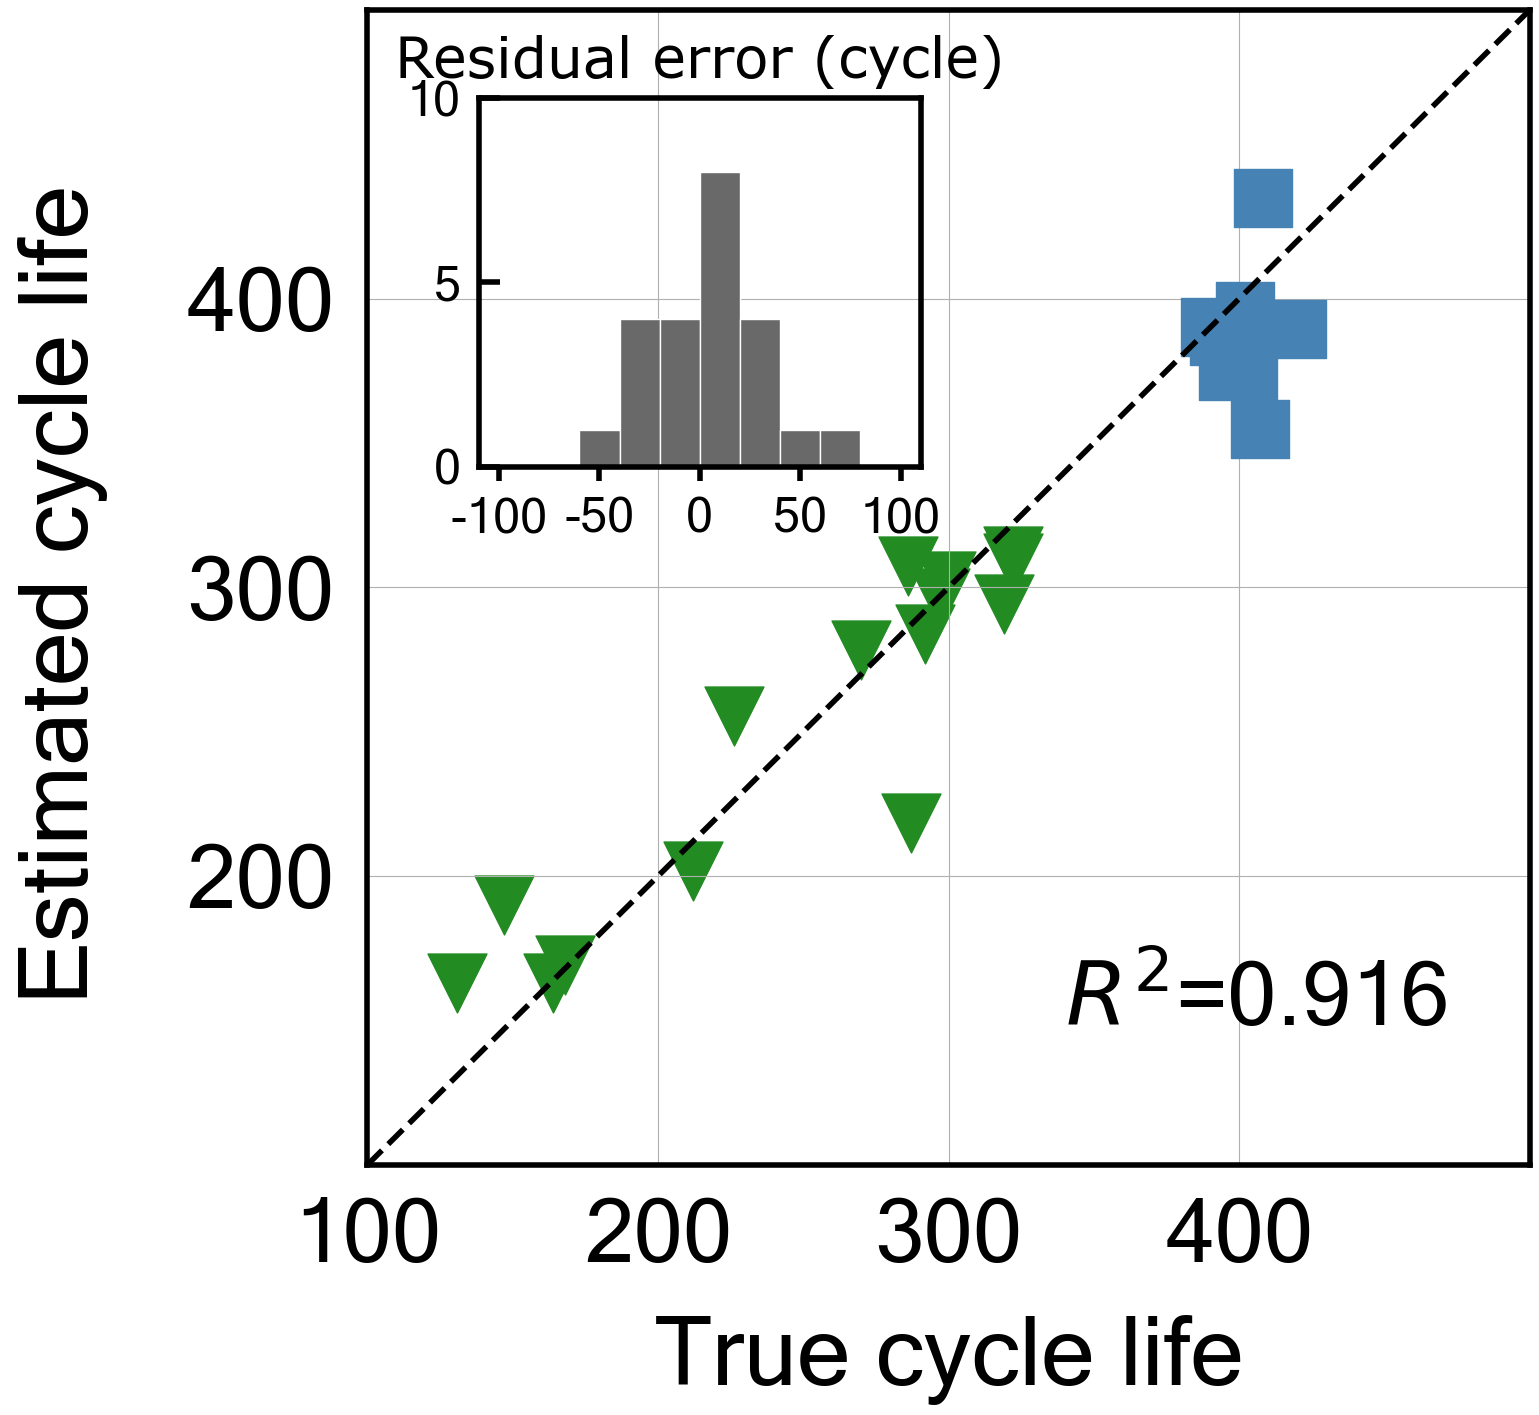


------------------------------------------------------------------------
Time elapsed: 8442.4
Best score obtained was: -28.305441107632078
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Max-Min', 'Average_2to10') : 0.0
T_V('Charge', 'Skewness', 'Average_2to10') : 0.19416344547881434
T_V('Charge', 'Kurtosis', 'Average_2to10') : -0.025021628279358856
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.0
dTdV('Charge', 'Variance', 'Average_2to10') : -0.0
dTdV('Charge', 'Mean', 'Average_2to10') : 0.0
dTdV('Charge', 'Skewness', 'Average_2to10') : 0.0
dTdV('Charge', 'Kurtosis', 'Average_2to10') : -0.0

Intercept: 0.6202443280977313
MAE_all: 34.7
MAPE_all: 13.0 %
RMSE_all: 40.7
RMSPE_all: 17.2 %
MAE_train: 28.9
MAPE_train: 13.8 %
RMSE_train: 35.7
RMSPE_train: 19.4 %
MAE_test: 45.5
MAPE_test: 11.3 %
RMSE_test: 48.6
RMSPE_test: 12.0 %
R2 normal-scale scores
All data r2-score: 0.798
Train data r2-score: 0.709
Test data r2-score: -28.305

Normal-scale scores
All data score: 0.798
Train data scor

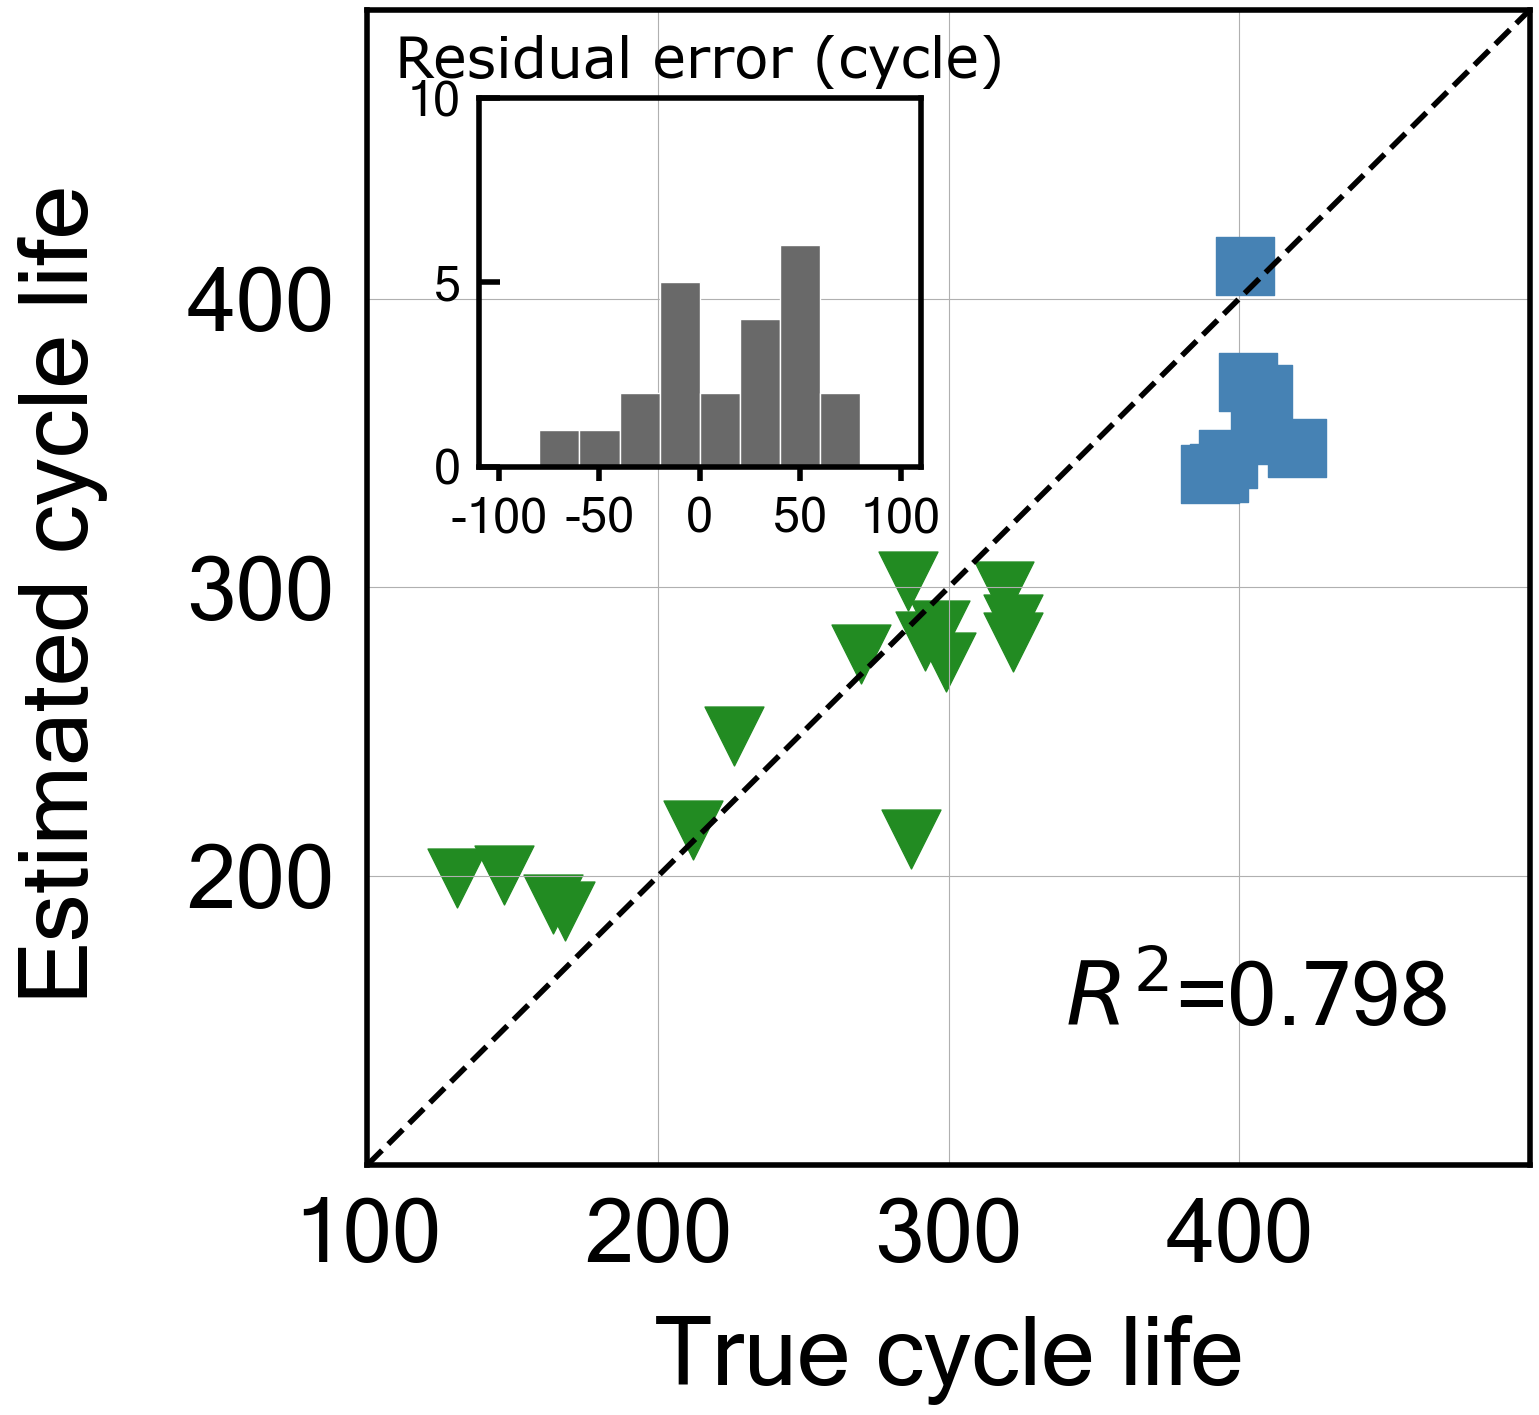


------------------------------------------------------------------------
Time elapsed: 8673.0
Best score obtained was: -39.069690128963714
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Minimum', 'Average_2to10') : 0.10171892555946184
T_V('Charge', 'Max-Min', 'Average_2to10') : -0.013038221748254272
T_V('Charge', 'Mean', 'Average_2to10') : 0.06787847750755617
T_V('Charge', 'Skewness', 'Average_2to10') : 0.13796812094571415
T_V('Charge', 'Kurtosis', 'Average_2to10') : -0.07216486302981821
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.07313563516541505
dTdV('Charge', 'Variance', 'Average_2to10') : -0.06428578557321978
dTdV('Charge', 'Mean', 'Average_2to10') : -6.752491240967525e-05
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.1107759130673451

Intercept: 0.6202443280977319
MAE_all: 23.9
MAPE_all: 8.5 %
RMSE_all: 39.2
RMSPE_all: 12.9 %
MAE_train: 18.5
MAPE_train: 8.5 %
RMSE_train: 25.1
RMSPE_train: 12.3 %
MAE_test: 33.9
MAPE_test: 8.4 %
RMSE_test: 56.9
RMSPE_test: 14.1 %
R2 norm

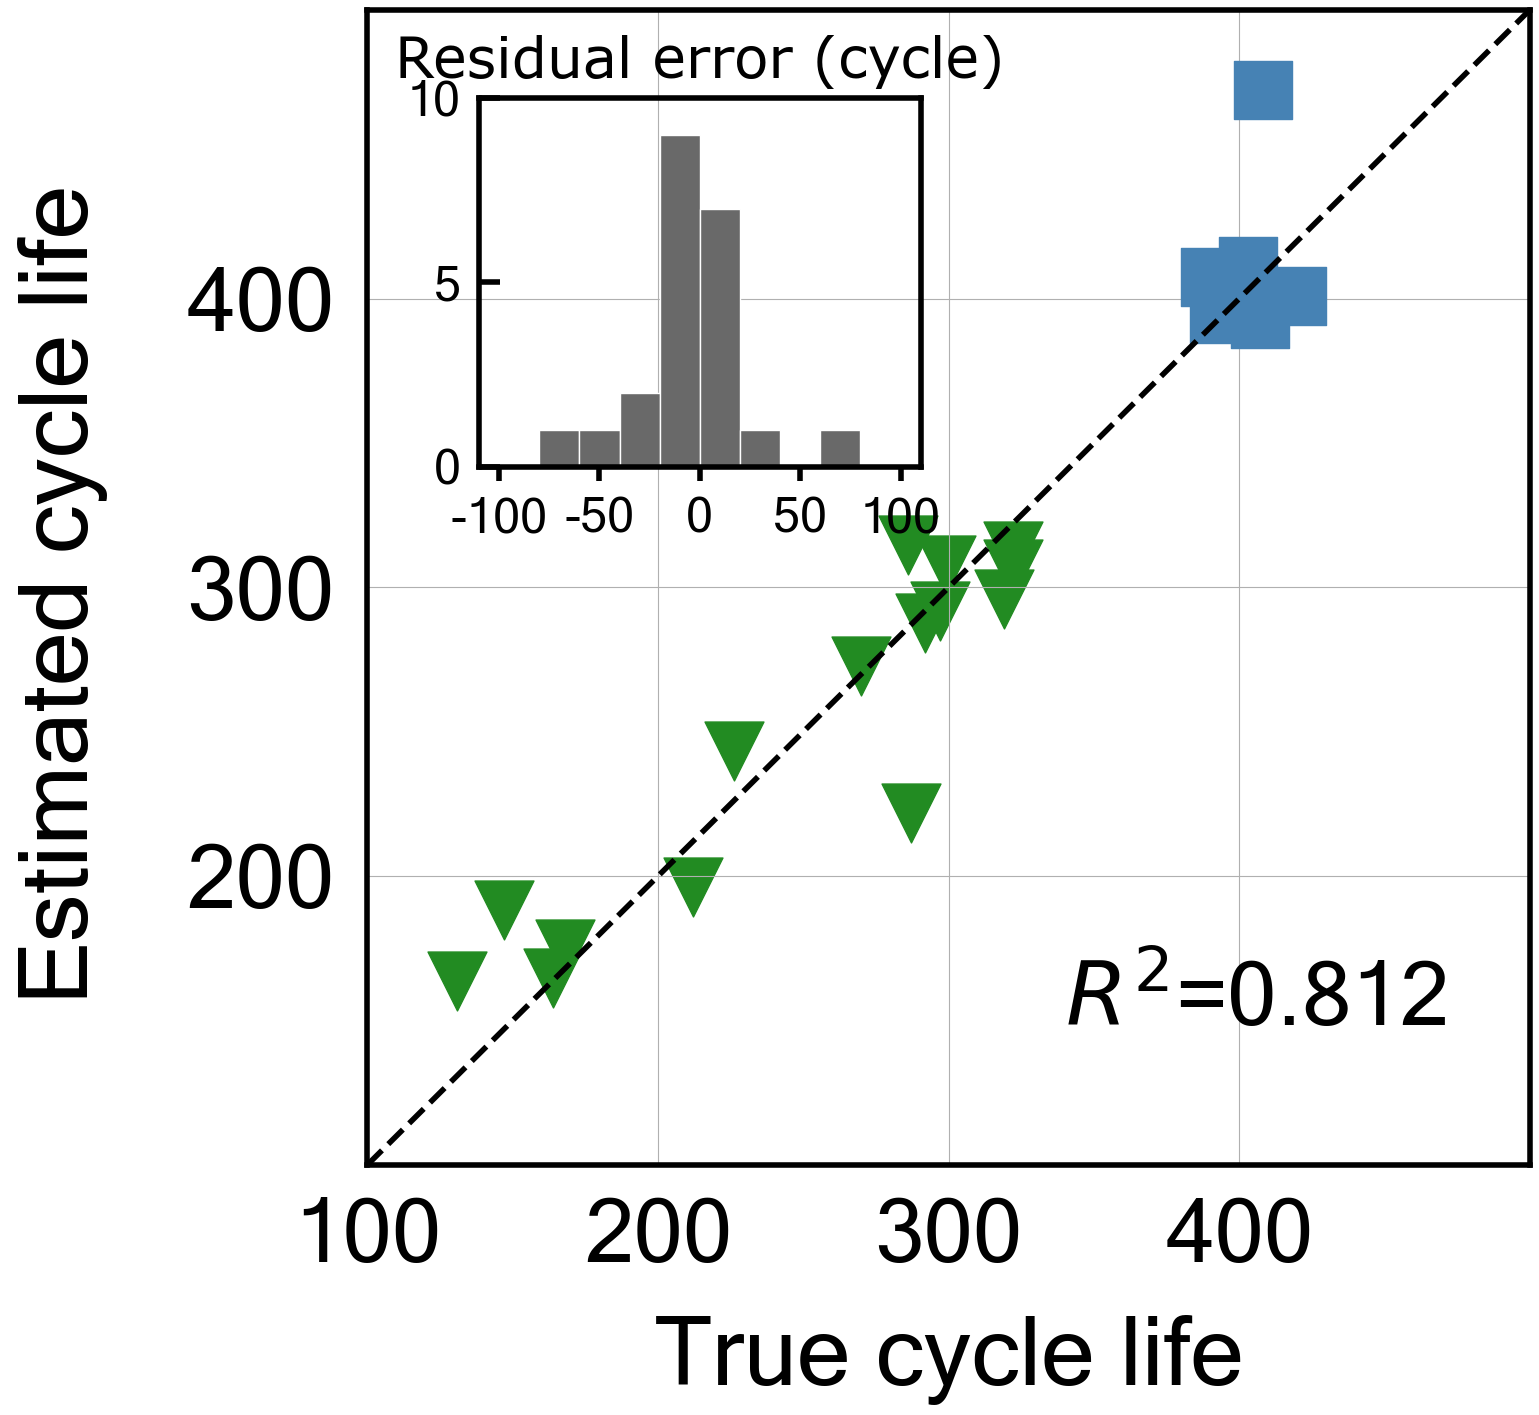


------------------------------------------------------------------------
Time elapsed: 8727.9
Best score obtained was: -45.43092517223981
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Minimum', 'Average_2to10') : 0.07473229311156077
T_V('Charge', 'Max-Min', 'Average_2to10') : 0.0
T_V('Charge', 'Variance', 'Average_2to10') : 0.0
T_V('Charge', 'Mean', 'Average_2to10') : 0.08552119871935907
T_V('Charge', 'Kurtosis', 'Average_2to10') : -0.059431043181338204
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.0
dTdV('Charge', 'Variance', 'Average_2to10') : 0.0
dTdV('Charge', 'Mean', 'Average_2to10') : 0.0
dTdV('Charge', 'Skewness', 'Average_2to10') : 0.0
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.0

Intercept: 0.6202443280977316
MAE_all: 40.2
MAPE_all: 14.7 %
RMSE_all: 47.6
RMSPE_all: 19.6 %
MAE_train: 29.9
MAPE_train: 14.7 %
RMSE_train: 38.4
RMSPE_train: 21.5 %
MAE_test: 59.4
MAPE_test: 14.8 %
RMSE_test: 61.2
RMSPE_test: 15.2 %
R2 normal-scale scores
All data r2-score: 0.723
Train d

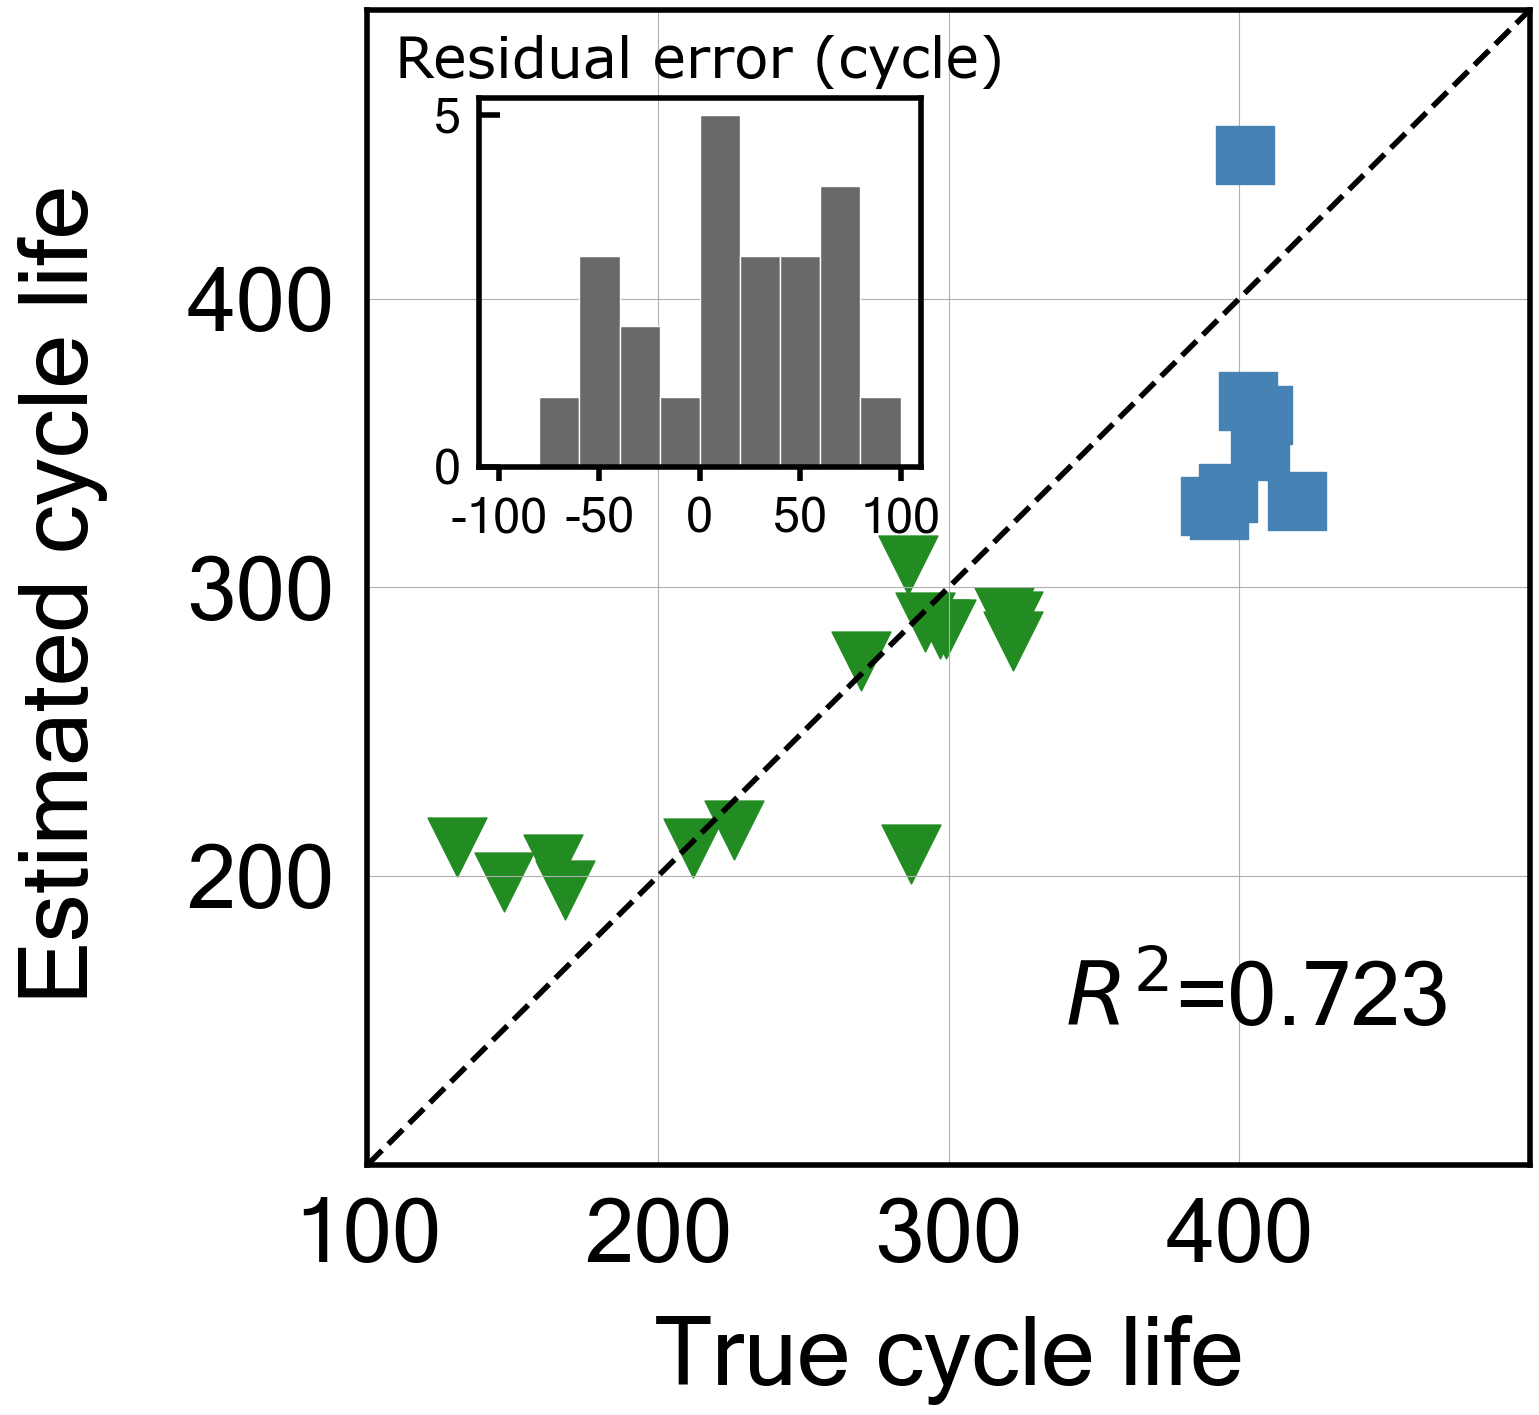


------------------------------------------------------------------------
Time elapsed: 8739.4
Best score obtained was: -84.28474889655395
Cycle no: Average_2to10
Coefficient:
T_V('Charge', 'Minimum', 'Average_2to10') : 0.07757871268065332
T_V('Charge', 'Max-Min', 'Average_2to10') : 0.0
T_V('Charge', 'Variance', 'Average_2to10') : 0.0
T_V('Charge', 'Mean', 'Average_2to10') : 0.0026535861883565364
T_V('Charge', 'Skewness', 'Average_2to10') : 0.16153730172228198
T_V('Charge', 'Kurtosis', 'Average_2to10') : -0.0
dTdV('Charge', 'Maximum', 'Average_2to10') : 0.0
dTdV('Charge', 'Variance', 'Average_2to10') : -0.0
dTdV('Charge', 'Mean', 'Average_2to10') : 0.0
dTdV('Charge', 'Skewness', 'Average_2to10') : 0.0
dTdV('Charge', 'Kurtosis', 'Average_2to10') : 0.0

Intercept: 0.620244328097732
MAE_all: 45.5
MAPE_all: 15.2 %
RMSE_all: 56.1
RMSPE_all: 19.2 %
MAE_train: 25.8
MAPE_train: 12.4 %
RMSE_train: 34.0
RMSPE_train: 18.4 %
MAE_test: 82.4
MAPE_test: 20.4 %
RMSE_test: 83.0
RMSPE_test: 20.5 %
R2 no

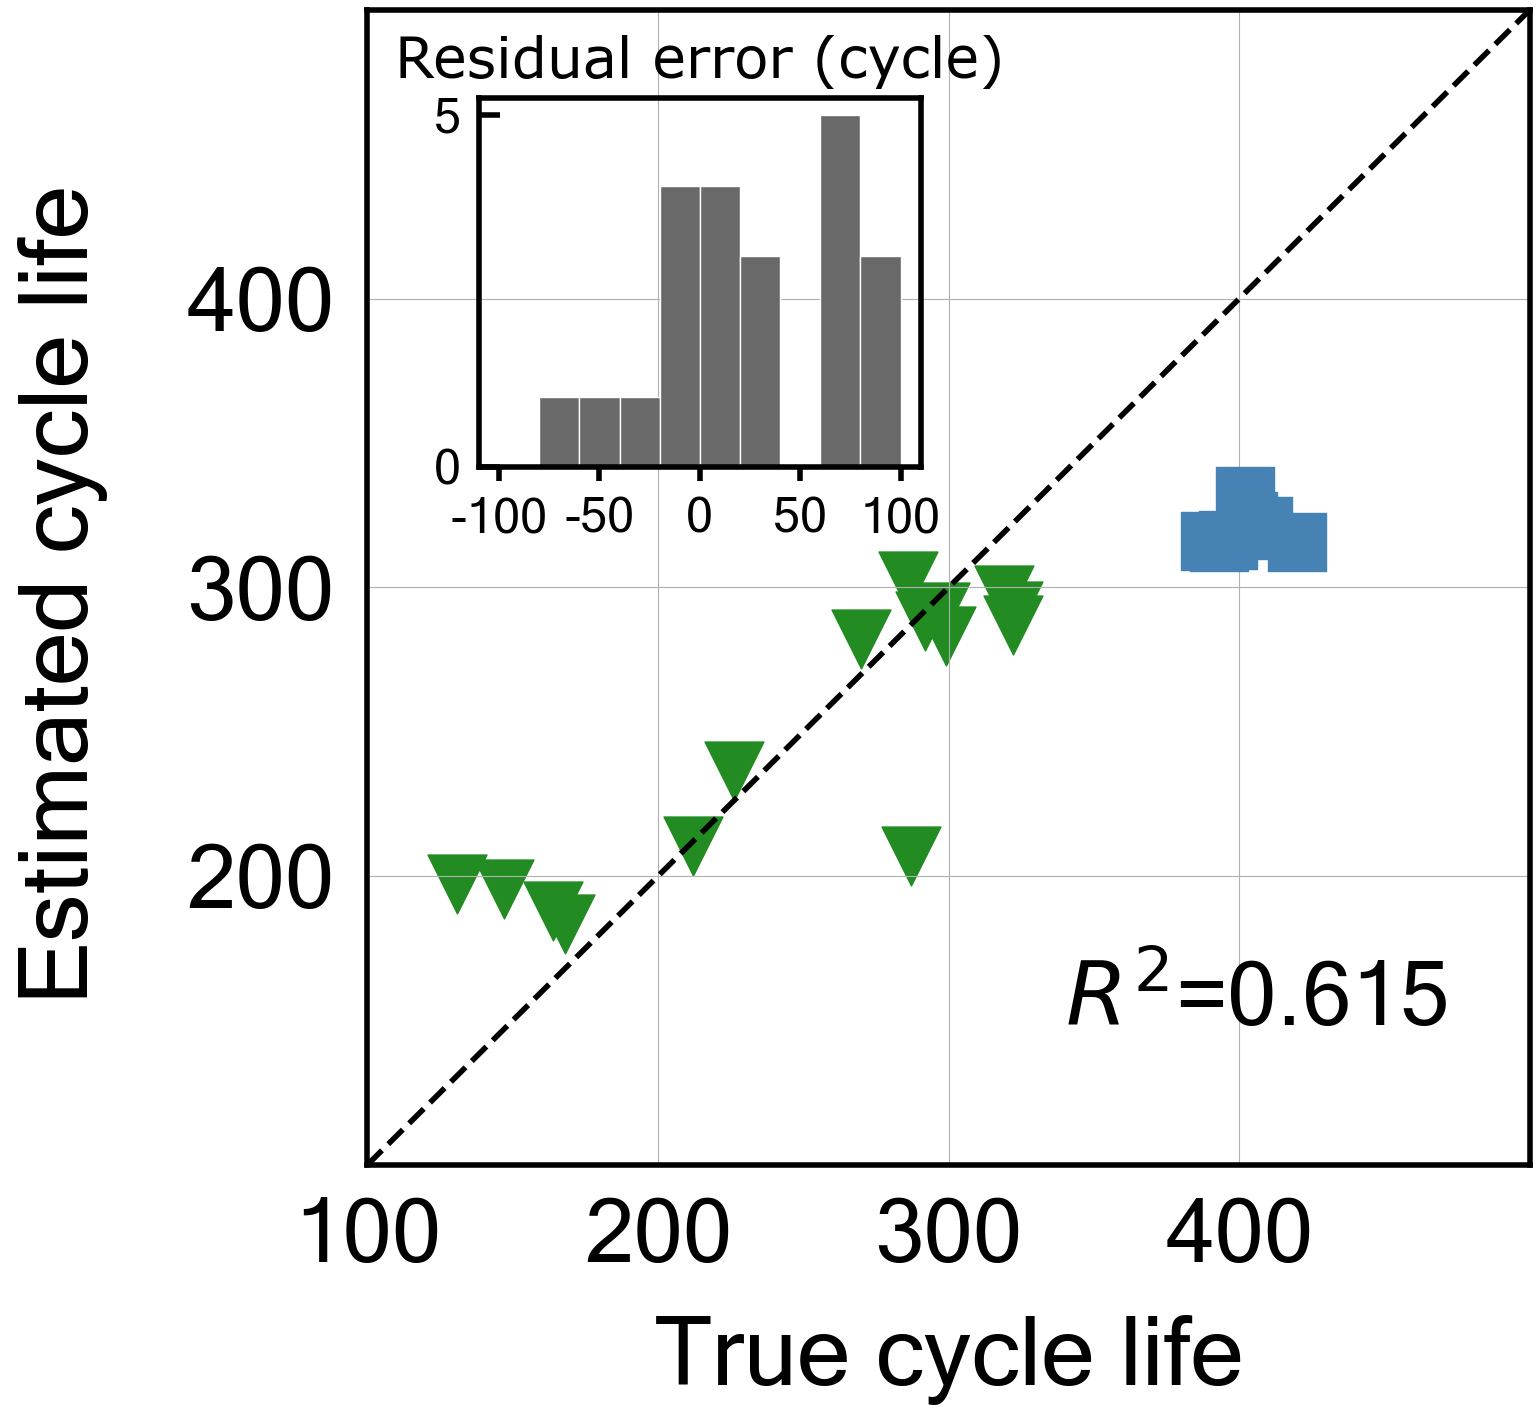

In [ ]:
# savepath = os.path.join('.', 'folder', 'filename')
# modelName = "Temperature model"
# columnIdx = featTemperatureChIndexList
    
# X_array = np.vstack(feat_df.loc[:, 'valueArray']).transpose()
# stringOutputList = []

# print("\nTemperature model\nrScore compared --> Test set")

# startTime = time.time()
# for i in range(1, len(columnIdx)+1):
#     r2ScoreBest = -100
#     featureKeynameListBest = []
#     saveFilePath = os.path.join(savepath, 'feat'+str(i)+'.png')
    
#     for combo in itertools.combinations(columnIdx, i):
#         featureKeynameList = []
#         X_all = X_array[:, combo]

#         for j in combo:
#             featureKeynameList.append(feat_df.loc[j, 'dictionary'] + str(feat_df.loc[j, 'featName']))

#         X_train  = X_all[train_index]
#         X_test = X_all[test_index]

#         scaler = StandardScaler().fit(X_train)
#         X_train_scaled = scaler.transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
#         X_all_scaled = np.concatenate((X_train_scaled, X_test_scaled))

#         # Train
#         regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=20, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random')
#         model = regEN
#         model.fit(X_train_scaled, y_train_scaled)

#         #Evaluate score: TEST SET
#         r2Score = model.score(X_test_scaled, y_test_scaled)
        
#         if r2Score > r2ScoreBest:
#             r2ScoreBest = r2Score
#             featureKeynameListBest = featureKeynameList
#             modelBest = model
#             X_all_scaled_best = X_all_scaled
            
#     stringOutputManual = ("\n------------------------------------------------------------------------\n" + 
#                     "Time elapsed: {:.1f}".format(time.time() - startTime) + 
#                     "\nBest score obtained was: " + str(r2ScoreBest))
#     print(stringOutputManual)
#     stringOutput = train_utils.print_result(setCycleNo, modelBest, X_all_scaled_best, y_all_scaled, featureKeynameListBest, idlst=lengthList, yScaler=yScaler)
#     stringOutput += plot_utils.build_all_comparison_graph(X_all_scaled_best, y_all_scaled, modelBest, len_list = [len(train_index), len(test_index)], yScaler=yScaler, 
#                                                           name=modelName, markerArr = markerArr, markerSize=1800, save = saveFilePath)
#     stringOutputList.append(stringOutputManual + stringOutput)
    
    
# with open(os.path.join(savepath, "output.txt"), "w") as f:
#     f.write('\n'.join(stringOutputList))
#     f.close()

## Below are the plots for the features used in the model
Scatter plot of features against cycle life, with pearson coefficient included, as well as feature weighting on the title

In [ ]:
textSize= 32
fontName='Microsoft Sans Serif'
lineWidth = 4

model = modelBest

combo = [3, 4, 5, 14, 18, 20]

for idxNo in range(len(combo)):
    rowNo = combo[idxNo]
    featArr = np.array(feat_df.loc[rowNo, 'valueArray']).reshape(-1, 1)
    scaler = StandardScaler().fit(featArr[train_index])
    featArr_scaled = scaler.transform(featArr)

    markerSize=550

    dictName, keyName = feat_df.loc[rowNo, ['dictionary', 'featName']]
    if "_" in dictName: titleName = keyName[1] + "(" + dictName.split('_')[0] + "[{}]-".format(dictName.split('_')[1]) + keyName[0] + ")"
    else: titleName = keyName[1] + "(d{}/d{}-".format(dictName.split('d')[1], dictName.split('d')[2]) + keyName[0] + ")"

    fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=1000)
    for axis in ['top', 'bottom', 'left', 'right']: 
        ax.spines[axis].set_linewidth(lineWidth)
        
    # Feature plot
    ax.tick_params(labelsize=textSize, left=True, bottom=True)
    ax.set_axisbelow(False)

    # Y-axis
    ax.yaxis.set_tick_params(direction='in', length=15, which='major', width=3)
    ax.yaxis.set_tick_params(length=-14, which='minor', width=2, labelsize=textSize)
    yTickArr = np.arange(200, 501, 200)
    yTickMinorArr = np.arange(100, 501, 200)
    ax.set_yticks(yTickArr)
    ax.set_yticklabels(yTickArr, fontname=fontName, x = -0.025)
    ax.set_yticks(yTickMinorArr, minor=True)
    ax.set_yticklabels(['-']*len(yTickMinorArr), minor=True)
    ax.set_ylim([0, 550])
    ax.yaxis.set_label_coords(-0.16, 0.5)
    ax.set_ylabel("Cycle life", fontsize=textSize+5, fontname=fontName)

    # X-axis
    ax.xaxis.set_tick_params(direction='in', length=10, which='major', width=4)
    xTickArr = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
    if(int(np.max(featArr_scaled)+1.2)-int(np.min(featArr_scaled)-1.2)) > 8: xTickArr = np.arange(int(np.min(featArr_scaled)-1.2), int(np.max(featArr_scaled)+1.2)+1, 3)
    ax.set_xticks(xTickArr)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xlim(int(np.min(featArr_scaled)-1.2)-0.5, int(np.max(featArr_scaled)+1.2)+0.5)
    ax.xaxis.set_label_coords(0.5, -0.13)
    ax.set_xticklabels(xTickArr, fontname=fontName, y = -0.02)
    ax.set_xlabel(titleName, fontsize=textSize+2, fontname=fontName)

    # Title: coefficient
    ax.set_title("w={:.3}".format(modelBest.coef_[idxNo]), fontsize=textSize, fontname=fontName, pad=12)

    # Text
    ax.text(x=0.62, y=0.12, s=r"$\rho$ = {:.2f}".format(r_regression(featArr_scaled, y)[0]), 
            color = 'k', fontsize=textSize, zorder=3, fontname=fontName, transform=ax.transAxes)

    # Plot
    for train in train_index: ax.scatter(featArr_scaled[train], y[train].item(), zorder = 1, s=markerSize, color='forestgreen', alpha=0.8, marker='v', edgecolors='k', linewidths=2)
    for test in test_index: ax.scatter(featArr_scaled[test], y[test].item(), zorder = 2, s=markerSize, color='darkorange', alpha=0.8, marker='s', edgecolors='k', linewidths=2)

    if '/' in titleName: 
        saveName = ''
        titleName = titleName.split('/')
        for name in titleName: saveName = saveName + name
    else: saveName = titleName
    save = os.path.join('.', 'folder', 'filename')
    # fig.savefig(save, dpi=1000, bbox_inches='tight', facecolor=(1,1,1,0))
    print(titleName)

    fig.show()

Variance(T[V]-Charge)
Mean(T[V]-Charge)
Skewness(T[V]-Charge)
['Maximum(dT', 'dV-Charge)']
['Mean(dT', 'dV-Charge)']
['Kurtosis(dT', 'dV-Charge)']
